# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Forecasting Hourly Orders for Sweet Lift Taxi Company

In [1]:
!pip install --user prophet
%pip install --user prophet

Note: you may need to restart the kernel to use updated packages.


## Preparation

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import arma_order_select_ic
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=[0])

except FileNotFoundError:
    
    print("The file was not found")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.sort_index(inplace=True)
#Newer version of Python requires increasing
df.index.is_monotonic_increasing

True

* Data is in order

In [6]:
#Copy later used for prophet
original = df.copy()

In [7]:
#Resample it by one hour
df = df.resample('1H').sum()
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.tail(5)

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [9]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year -> Data does not provide useful information 
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #Added in hr
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
#max lag = 2 and 24 hr time frame for rolling mean size
make_features(df, 2, 24)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.iloc[:, 1:]
target_train = train.iloc[:, 0]
features_test = test.iloc[:, 1:]
target_test = test.iloc[:, 0]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   hour          4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   rolling_mean  4392 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 310.5 KB


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   month         3950 non-null   int64  
 2   day           3950 non-null   int64  
 3   dayofweek     3950 non-null   int64  
 4   hour          3950 non-null   int64  
 5   lag_1         3950 non-null   float64
 6   lag_2         3950 non-null   float64
 7   rolling_mean  3950 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 277.7 KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    442 non-null    int64  
 1   month         442 non-null    int64  
 2   day           442 non-null    int64  
 3   dayofweek     442 non-null    int64  
 4   hour          442 non-null    int64  
 5   lag_1         442 non-null    float64
 6   lag_2         442 non-null    float64
 7   rolling_mean  442 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 31.1 KB


# Analysis

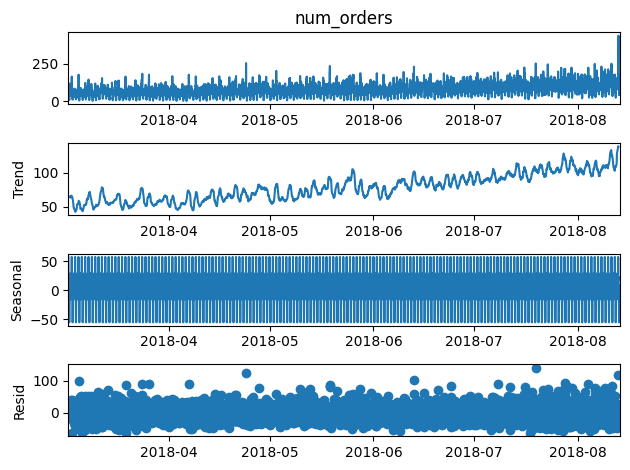

In [13]:
decomposition = seasonal_decompose(train['num_orders'])
decomposition.plot()
plt.show()

<AxesSubplot:xlabel='datetime'>

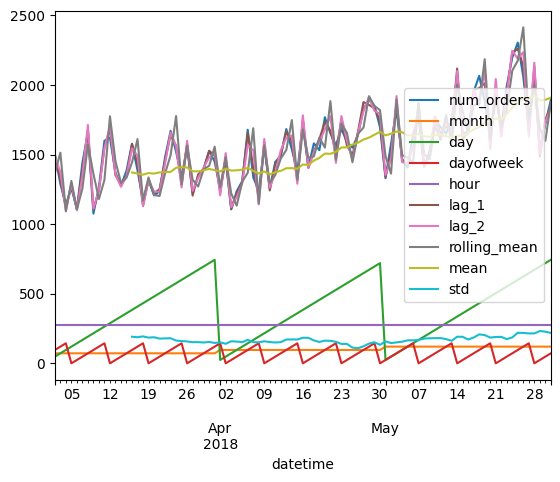

In [14]:
data = train['2018-03':'2018-05'].resample('1D').sum()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

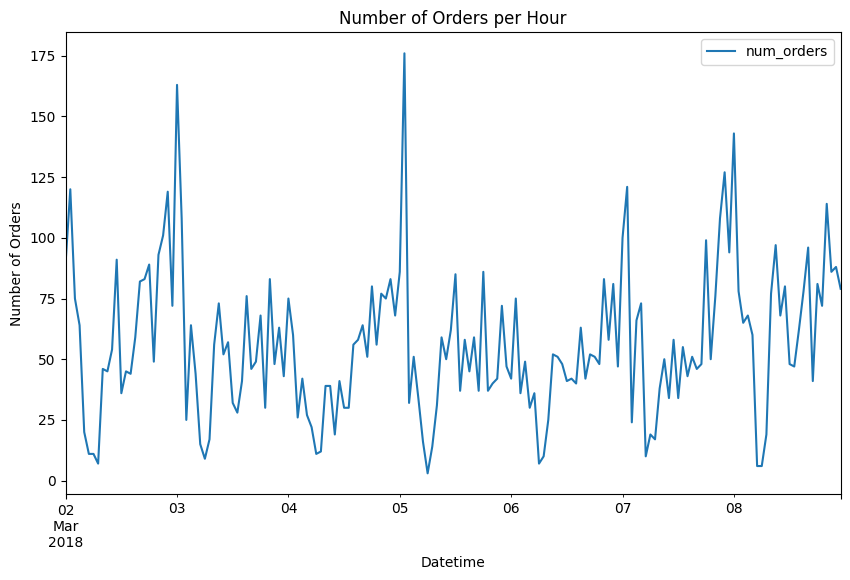

In [15]:
data = train['2018-03-01':'2018-03-08'].resample('1H').sum()
data['num_orders'].plot(figsize=(10, 6), title='Number of Orders per Hour', legend=True)
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()

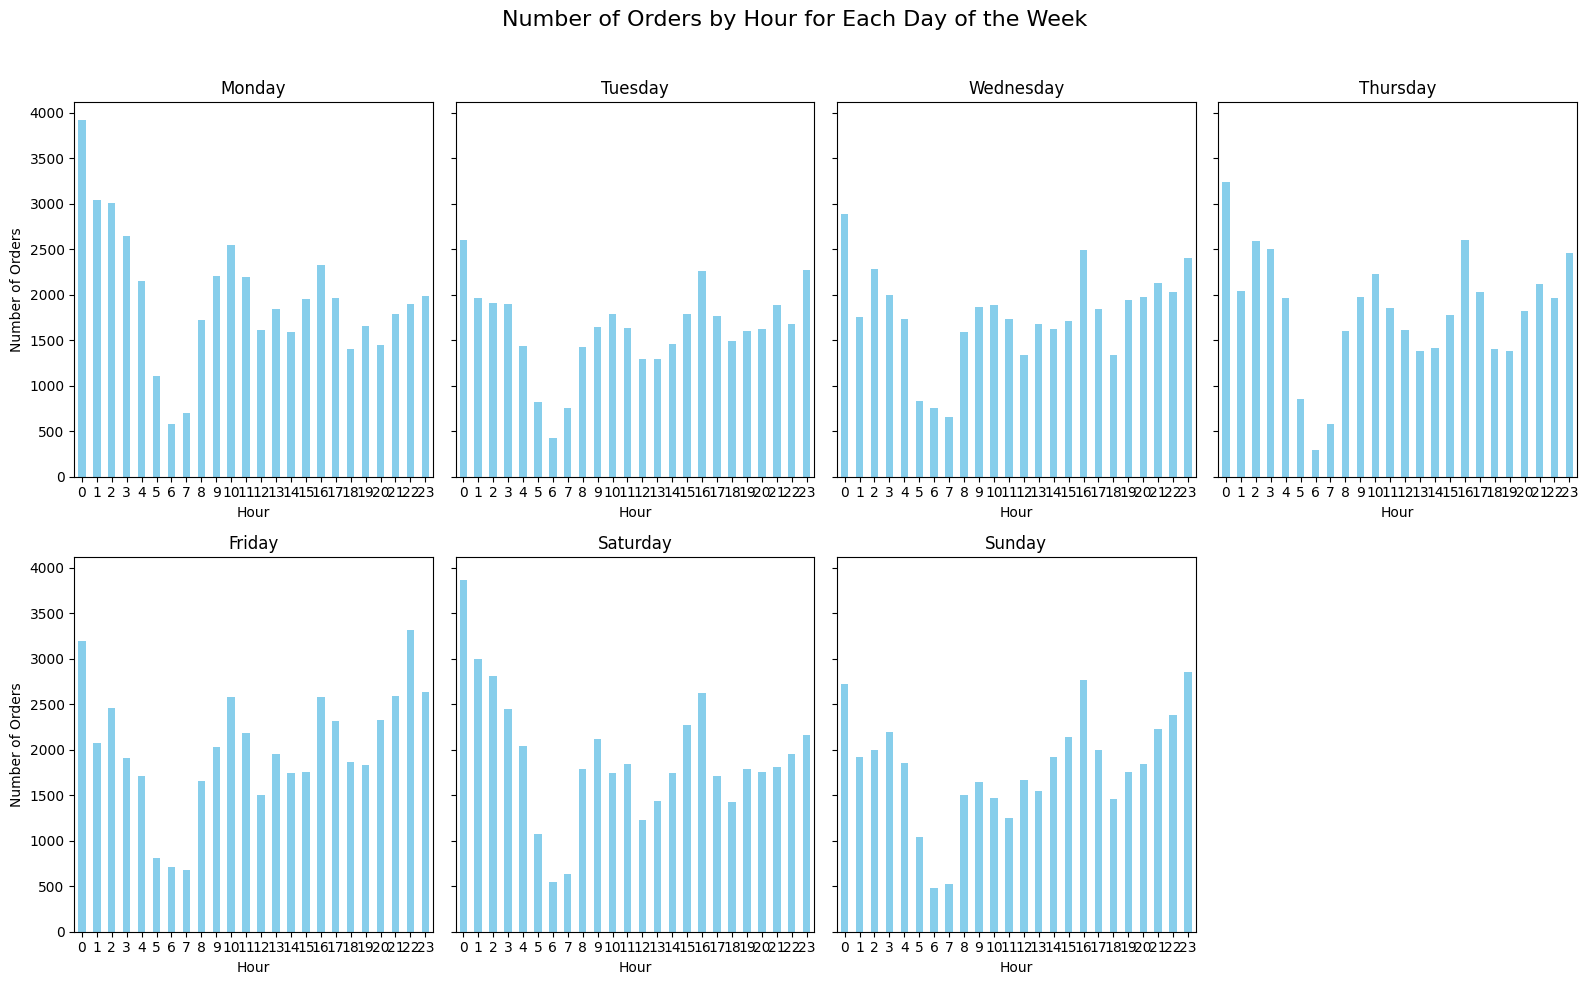

In [16]:
orders = train.copy()
orders['hour'] = train.index.hour
orders['dayofweek'] = train.index.dayofweek

# Prepare subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), sharey=True)
fig.suptitle('Number of Orders by Hour for Each Day of the Week', fontsize=16)

# Days of the week labels
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot each day of the week
for i, ax in enumerate(axes.flatten()[:-1]):
    orders_day = orders[orders['dayofweek'] == i].groupby('hour')['num_orders'].sum()
    orders_day.plot(kind='bar', ax=ax, title=day_labels[i], color='skyblue')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Orders')
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24), rotation=0)

# Hide the last empty subplot
axes.flatten()[-1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* Repeating daily pattern
* Seasonal plot is cyclical meaning seasonality does exits and is repeated consistently over the whole dataset. Data was collected over 6 months
on a daily basis. 
* Oth hour always has the highest amount of orders then they all seem to decrease by the 6th and 7th hour abd face another peak around the 15th to 16th hour. Friday nights are different with more taxi orders at night.

# Forecasting Accuracy

In [17]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
rmse = np.sqrt(mean_squared_error(test['num_orders'], pred_previous))
print('RMSE:', rmse)

RMSE: 58.856486242815066


* Baseline model gives an RMSE of 58. Not good enough

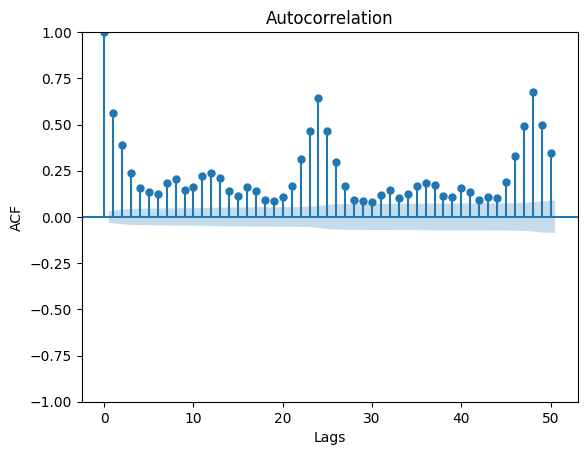

In [18]:
lags_to_check = 50
acf = plot_acf(x=train['num_orders'], lags=lags_to_check)

plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

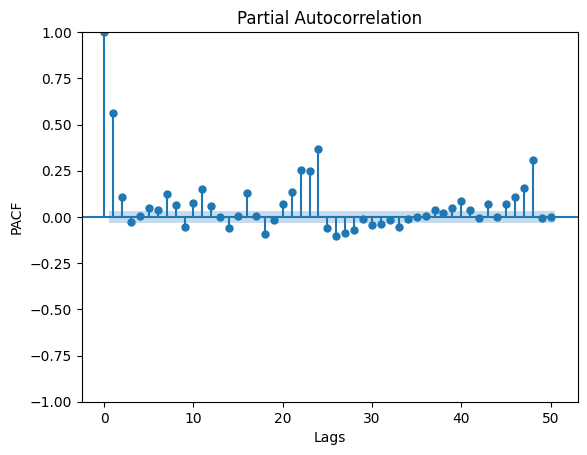

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
lags_to_check = 50
pacf = plot_pacf(x=train['num_orders'], lags=lags_to_check)  # fill in arguments here

plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

* 3rd lag falls within the confidence interval and, therefore, stops our count at two. This value is hard coded in the previous make features function
  call

# Training

# Auto Regression

In [20]:
# Select AR order using ar_select_order
mod = ar_select_order(endog=train['num_orders'], maxlag=200)
ar_order = mod.ar_lags

# Create and fit the AR model using the training set
ar_model = AutoReg(train['num_orders'], lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

# Make predictions on the training set
train_pred = ar_model.predict(start=ar_order[-1], end=len(train) - 1, dynamic=False)

# Evaluate model using RMSE on the training set
train_rmse_value = np.sqrt(mean_squared_error(train['num_orders'][ar_order[-1]:], train_pred))
print("Training RMSE:", train_rmse_value)

Training RMSE: 20.13539655926256


# Moving Average

In [21]:
res = arma_order_select_ic(y=train['num_orders'], max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]  # Extract MA order from res
print("Output of the arma_order_select_ic() function is:", res.bic_min_order)

# Step 2: Create and fit the MA model using the training set
ma_model = ARIMA(train['num_orders'], order=(0, 0, ma_order))  # Specify order for MA model
ma_model = ma_model.fit()

# Step 3: Make predictions on the training set
train_pred = ma_model.predict(start=ma_order, end=len(train) - 1, dynamic=False)

# Step 4: Evaluate model using RMSE on the training set
train_rmse_value = np.sqrt(mean_squared_error(train['num_orders'][ma_order:], train_pred))
print("Training RMSE:", train_rmse_value)

Output of the arma_order_select_ic() function is: (0, 8)
Training RMSE: 31.281870992414913


# Autoregressive Moving Average model

In [22]:
#def rmse(y_true, y_pred):
#    return np.sqrt(mean_squared_error(y_true, y_pred))
#rmse_score = make_scorer(rmse)

In [23]:
#model = auto_arima(train['num_orders'], seasonal=True, m=24, scoring= rmse_score)

In [24]:
#train_pred = model.predict_in_sample()
#rmse_train = np.sqrt(mean_squared_error(train['num_orders'], train_pred))
#print("Training RMSE:", rmse_train)

In [25]:
#model.summary()

* Sarima by far has the best RMSE on training set. 

# Prophet

In [26]:
#Check len of test for input in prophet
len(test)

442

In [27]:
original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [28]:
prophet_df = pd.DataFrame({
    'ds': original.index,
    'y': original['num_orders']
})

train = prophet_df[:-442]  # Train on all but the last 442 points

#Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

#Make predictions on the training set
train_forecast = model.predict(train[['ds']])  # Use the dates from the training set for prediction

# Step 5: Calculate RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(train['y'], train_forecast['yhat']))
print('Training RMSE:', rmse_train)

20:12:26 - cmdstanpy - INFO - Chain [1] start processing
20:12:31 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 6.85862124936025


* RMSE is lowest on prophet model. Time for testing. 

# Testing

In [29]:
test = prophet_df[-442:]   # Test on the last 442 points

# Create a DataFrame for future predictions (442 periods into the future)
future = model.make_future_dataframe(periods=442, freq='H')  #'H' for hourly

# Generate forecasts
forecast = model.predict(future)

# Slice the forecast to only include the predictions matching y_test
forecast_test = forecast[-442:]  # Last 442 predictions

rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print('RMSE:', rmse)

RMSE: 14.502231109774659


# Conclusion

Prophet is a robust forecasting library that effectively handles outliers and missing data, which contributes to its strong performance in terms of RMSE. In our analysis, we observed significant fluctuations towards the end of the dataset, particularly within the 6-month cycle, which the Prophet model captured well. Given these factors, I recommend that Sweet Lift Taxi use the Prophet model to predict the number of taxi orders for the next hour.